In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, ZeroPadding2D, BatchNormalization, MaxPool2D, Add
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from PIL import Image
from functools import wraps, partial, reduce
from tensorflow import zeros
from tensorflow.keras import Input, Model

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorboard

physical_devices = tf.config.experimental.list_physical_devices('GPU') 
for physical_device in physical_devices: 
    tf.config.experimental.set_memory_growth(physical_device, True)

%load_ext tensorboard

 # Implementing the DarkNet 53

 The cnn consists of a 53 layer deep nn each layer is followed by BN and a Leaky relu activation. Downsampling is done using the conv layers with stride 2.
 First step is to overload the BatchNorm Block.

In [3]:
from tensorflow.python.keras.layers import DepthwiseConv2D
from tensorflow.python.keras.regularizers import l2
# class BatchNormalization(BatchNormalization):
#     def call(self, x, training=False):
#         if not training:
#             training = tf.constant(training)
#         training = tf.logical_and(self.trainable, training)
#         return super().call(x, training)



In [4]:
# def convolutional(input_layer, filters_shape, downsample=False, activate=True, bn=True):
#     if downsample:
#         input_layer = ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
#         padding = 'valid'
#         strides = 2
#     else:
#         strides = 1
#         padding = 'same'
#
#     conv = Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], strides=strides,
#                   padding=padding, use_bias=not bn, kernel_regularizer=l2(0.0005),
#                   kernel_initializer=tf.random_normal_initializer(stddev=0.01),
#                   bias_initializer=tf.constant_initializer(0.))(input_layer)
#     if bn:
#         conv = BatchNormalization()(conv)
#     if activate == True:
#         conv = LeakyReLU(alpha=0.1)(conv)
#
#     return conv



In [5]:
_DarknetConv2D = partial(Conv2D, padding='same')

@wraps(Conv2D)
def darknet_conv_2d(*args, **kwargs):
    default_dict = {'kernel_regularizer': l2(5e-4)}
    default_dict.update(kwargs)
    return _DarknetConv2D(*args, **default_dict)


# Partial wrapper for Convolution2D with static default argument.
_DarknetConv2D = partial(Conv2D, padding='same')


def compose(*funcs):
    """Compose arbitrarily many functions, evaluated left to right.
    Reference: https://mathieularose.com/function-composition-in-python/
    """
    # return lambda x: reduce(lambda v, f: f(v), funcs, x)
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')


@wraps(Conv2D)
def DarknetConv2D(*args, **kwargs):
    """Wrapper to set Darknet weight regularizer for Convolution2D."""
    darknet_conv_kwargs = {'kernel_regularizer': l2(5e-4)}
    darknet_conv_kwargs.update(kwargs)
    return _DarknetConv2D(*args, **darknet_conv_kwargs)


@wraps(DepthwiseConv2D)
def DarknetDepthwiseConv2D(*args, **kwargs):
    """Wrapper to set Darknet parameters for Convolution2D."""
    darknet_conv_kwargs = {'kernel_regularizer': l2(5e-4)}
    darknet_conv_kwargs['padding'] = 'valid' if kwargs.get('strides')==(2,2) else 'same'
    darknet_conv_kwargs.update(kwargs)
    return DepthwiseConv2D(*args, **darknet_conv_kwargs)


def Darknet_Depthwise_Separable_Conv2D_BN_Leaky(filters, kernel_size=(3, 3), block_id_str=None, **kwargs):
    """Depthwise Separable Convolution2D."""
    if not block_id_str:
        block_id_str = str(K.get_uid())
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        DarknetDepthwiseConv2D(kernel_size, name='conv_dw_' + block_id_str, **no_bias_kwargs),
        BatchNormalization(name='conv_dw_%s_bn' % block_id_str),
        LeakyReLU(alpha=0.1, name='conv_dw_%s_leaky_relu' % block_id_str),
        Conv2D(filters, (1,1), padding='same', use_bias=False, strides=(1, 1), name='conv_pw_%s' % block_id_str),
        BatchNormalization(name='conv_pw_%s_bn' % block_id_str),
        LeakyReLU(alpha=0.1, name='conv_pw_%s_leaky_relu' % block_id_str))


def Depthwise_Separable_Conv2D_BN_Leaky(filters, kernel_size=(3, 3), block_id_str=None):
    """Depthwise Separable Convolution2D."""
    if not block_id_str:
        block_id_str = str(K.get_uid())
    return compose(
        DepthwiseConv2D(kernel_size, padding='same', name='conv_dw_' + block_id_str),
        BatchNormalization(name='conv_dw_%s_bn' % block_id_str),
        LeakyReLU(alpha=0.1, name='conv_dw_%s_leaky_relu' % block_id_str),
        Conv2D(filters, (1,1), padding='same', use_bias=False, strides=(1, 1), name='conv_pw_%s' % block_id_str),
        BatchNormalization(name='conv_pw_%s_bn' % block_id_str),
        LeakyReLU(alpha=0.1, name='conv_pw_%s_leaky_relu' % block_id_str))


def DarknetConv2D_BN_Leaky(*args, **kwargs):
    """Darknet Convolution2D followed by BatchNormalization and LeakyReLU."""
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        DarknetConv2D(*args, **no_bias_kwargs),
        BatchNormalization(),
        LeakyReLU(alpha=0.1))


def bottleneck_block(outer_filters, bottleneck_filters):
    """Bottleneck block of 3x3, 1x1, 3x3 convolutions."""
    return compose(
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)),
        DarknetConv2D_BN_Leaky(bottleneck_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)))


def bottleneck_x2_block(outer_filters, bottleneck_filters):
    """Bottleneck block of 3x3, 1x1, 3x3, 1x1, 3x3 convolutions."""
    return compose(
        bottleneck_block(outer_filters, bottleneck_filters),
        DarknetConv2D_BN_Leaky(bottleneck_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)))


def space_to_depth_x2(x):
    """Thin wrapper for Tensorflow space_to_depth with block_size=2."""
    # Import currently required to make Lambda work.
    # See: https://github.com/fchollet/keras/issues/5088#issuecomment-273851273
    import tensorflow as tf
    return tf.nn.space_to_depth(x, block_size=2)


def space_to_depth_x2_output_shape(input_shape):
    """Determine space_to_depth output shape for block_size=2.
    Note: For Lambda with TensorFlow backend, output shape may not be needed.
    """
    return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, 4 *
            input_shape[3]) if input_shape[1] else (input_shape[0], None, None,
                                                    4 * input_shape[3])


 defining the Darknet res connection

In [6]:
def resblock_body(x, num_filters, num_blocks):
    '''A series of resblocks starting with a downsampling Convolution2D'''
    # Darknet uses left and top padding instead of 'same' mode
    x = ZeroPadding2D(((1,0),(1,0)))(x)
    x = DarknetConv2D_BN_Leaky(num_filters, (3,3), strides=(2,2))(x)
    for i in range(num_blocks):
        y = compose(
                DarknetConv2D_BN_Leaky(num_filters//2, (1,1)),
                DarknetConv2D_BN_Leaky(num_filters, (3,3)))(x)
        x = Add()([x,y])
    return x



def darknet53_body(x):
    '''Darknet53 body having 52 Convolution2D layers'''
    x = DarknetConv2D_BN_Leaky(32, (3,3))(x)
    x = resblock_body(x, 64, 1)
    x = resblock_body(x, 128, 2)
    x = resblock_body(x, 256, 8)
    x = resblock_body(x, 512, 8)
    x = resblock_body(x, 1024, 4)
    return x


In [7]:
layer_outputs = []
# mock_inputs = zeros((224, 224, 3, 100))
for i in range(1, 40):
    inputs = Input(shape=(224*i, 224*i, 3))
    x = darknet53_body(inputs)
    model = Model(inputs=inputs, outputs=x, name="mnist_model")
    layer_outputs += [{'input': 224*i, 'output': model.layers[-1].output.shape[1]}]
    print(f'iteration {i} input: {224*i}, {224*i} returns {model.layers[-1].output.shape}')


# %%


In [8]:
results = pd.DataFrame(layer_outputs)
sns.regplot(x='input', y='output', data=results)
plt.show()

NameError: name 'layer_outputs' is not defined

Augmenting the darknet body to reduce dimensions dow to 8, 8, 1024:

In [9]:

def darknet53_body(x):
    '''Darknet53 body having 52 Convolution2D layers'''
    x = DarknetConv2D_BN_Leaky(32, (3,3))(x)
    x = resblock_body(x, 64, 1)
    x = resblock_body(x, 128, 2)
    x = resblock_body(x, 256, 4)
    x = resblock_body(x, 512, 4)
    x = resblock_body(x, 1024, 8)
    x = resblock_body(x, 1024, 8)
    x = resblock_body(x, 1024, 10)
    x = resblock_body(x, 1024, 10)
    x = resblock_body(x, 1024, 20)
    x = MaxPool2D(pool_size=(2,2), strides=(4,4))(x)
    x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
    return x


In [13]:
tb_path = "logs/"
inputs = Input(shape=(224*200, 224*200, 3))
x = darknet53_body(inputs)
model = Model(inputs=inputs, outputs=x, name="mnist_model")
graph = tf.compat.v1.keras.backend.get_session().graph
print(f'input: {224*200}, {224*200} returns {model.layers[-1].output.shape}')
model.summary()
print(f'og: 185, new size: {len(model.layers)}: depth increase = {len(model.layers)/ 185}')



input: 44800, 44800 returns (None, 11, 11, 1024)
Model: "mnist_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 44800, 44800 0                                            
__________________________________________________________________________________________________
conv2d_288 (Conv2D)             (None, 44800, 44800, 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_288 (BatchN (None, 44800, 44800, 128         conv2d_288[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_288 (LeakyReLU)     (None, 44800, 44800, 0           batch_normalization_288[0][0]    
_______________________________________

The trainable params would increase to 344568544 an 8 fold increase.
8.49006172931981

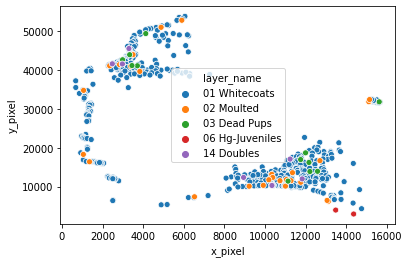

In [18]:
from pandas import read_excel, DataFrame

locations = read_excel('/home/md273/CS5099-working-copy/data/pixel_coord.xlsx', sheet_name='PixelCoordinates')[['tiff_file', 'layer_name', 'x_pixel', 'y_pixel']]
sns.scatterplot(x='x_pixel', y='y_pixel', hue='layer_name', data=locations[locations['tiff_file']=='StitchMICE_ORKsi16_3_1103_CP_FINAL.tif'])

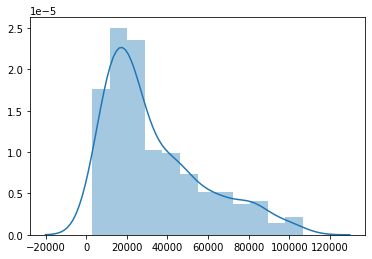

In [21]:
file_contents = read_excel('/home/md273/CS5099-working-copy/data/PixelCoordinates_HgPupCounts2016_VersionToUse_20181017-1.xlsx', sheet_name='FileOverview')
sns.distplot(file_contents[['image_width']])

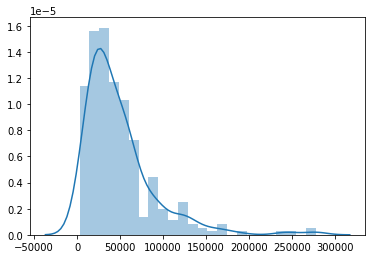

In [22]:
sns.distplot(file_contents[['image_height']])